In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import os

In [3]:
df = pd.read_csv(os.path.join('..','data','brfss.csv'))
df = df.dropna(subset=['htm3','wtkg2'])

In [4]:
df.head()

,Unnamed: 0,age,sex,wtyrago,finalwt,wtkg2,htm3
0,0,82.0,2,76.363636,185.870345,70.91,157.0
1,1,65.0,2,72.727273,126.603027,72.73,163.0
3,3,61.0,1,73.636364,517.926275,73.64,170.0
4,4,26.0,1,88.636364,1252.624630,88.64,185.0
5,5,42.0,1,118.181818,415.161314,109.09,183.0


7.1 Scatter plot
----

plotting scatter plots in 4 different ways - 
1. Normal scatter plot
2. Jittering - adding random noise to the data to make the scatter plot clearer
3. Making the plot transperent using alpha keyword, if the scatter plot is heavily dense in a particular region
4. Hexbin plot - the plot is like countour plot - divides the graph into hexagonal bins - each bin is coloured as per the number of data in that bin

In [5]:
def jitter_data(values,level=0.5):
    return np.random.uniform(-level,level,len(values)) + values

def eval_cdf(value,series):
    count =0
    for x in series:
        if x <= value:
            count += 1
    return count/len(series)

def compute_cdf(series):
    x = sorted(list(series))
    y = []
    for value in x:
        y.append(eval_cdf(value,x))
    return x,y

# Percentile(p): Given a percentile rank p, computes the corresponding value, x. Equivalent to Value(p/100)
def percentile(p,series):
    series, cdfs = compute_cdf(series)
    if p < min(cdfs):
        p = min(cdfs)
    return series[cdfs.index(max([cdf for cdf in cdfs if cdf <=p]))]

Text(0.5,1,'Jittered data')

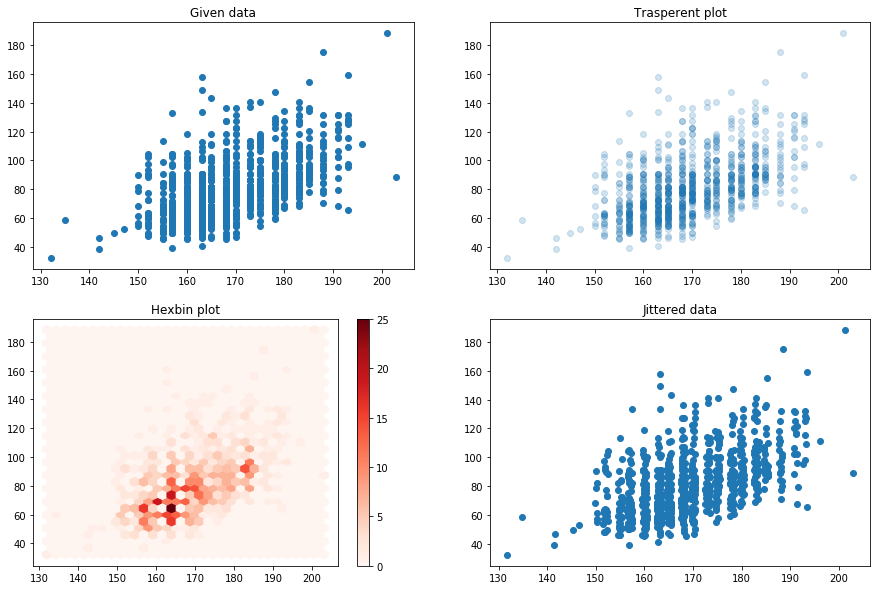

In [6]:
# subplot(nrows, ncols, index, **kwargs)
fig = plt.figure()
fig.set_size_inches(15,10)

# add a automated to plot n by n number of subplots with titles and axis labels

# Normal scatter plot
ax1 = plt.subplot(221)
ax1.scatter(df['htm3'],df['wtkg2'])
ax1.set_title('Given data')

# Transperent plot
ax2 = plt.subplot(222)
ax2.scatter(df['htm3'],df['wtkg2'],alpha=0.2)
ax2.set_title('Trasperent plot')

# Hexbin plot
ax3 = plt.subplot(223)
fig.colorbar(ax3.hexbin(df['htm3'],df['wtkg2'],gridsize=30,cmap=plt.cm.Reds))
ax3.set_title('Hexbin plot')

# Jitter plot - adding random noise
height_jitter = jitter_data(df['htm3'],level=0.5)
wgt_jitter = jitter_data(df['wtkg2'],level=0.5)

ax4 = plt.subplot(224)
ax4.scatter(height_jitter,wgt_jitter)
ax4.set_title('Jittered data')


It is not easy to plot a scatter plot that shows the relationship clearly

7.2 Characterizing relationship
---------------

bin one variable and plot percentiles of other variable

In [7]:
# step 1
bins = np.arange(min(df['htm3']), max(df['htm3']),5)
bins

array([132., 137., 142., 147., 152., 157., 162., 167., 172., 177., 182.,
       187., 192., 197., 202.])

In [8]:
# step 2 - grouping values as per bins
indices = np.digitize(df['htm3'],bins)
groups = df.groupby(indices)
for i,group in groups:
    print ('group no.',i,group.head())
# the grouping is done as per the indices provided and each index contains a dataframe

group no. 1      Unnamed: 0   age  sex    wtyrago      finalwt  wtkg2   htm3
102         102  81.0    2  45.454545  2454.935430  32.27  132.0
401         401  82.0    2  58.636364   529.432295  58.64  135.0
group no. 3      Unnamed: 0   age  sex    wtyrago     finalwt  wtkg2   htm3
379         379  85.0    2  61.363636  529.432295  50.00  145.0
430         430  63.0    2  47.727273  503.977432  46.36  142.0
765         765  41.0    2  63.636364  163.550308  38.64  142.0
group no. 4      Unnamed: 0   age  sex    wtyrago      finalwt  wtkg2   htm3
135         135   NaN    2  61.363636   308.647976  61.36  150.0
212         212  26.0    2  54.545455  1330.804080  54.55  150.0
383         383  59.0    2  93.636364   385.406540  81.82  150.0
806         806  68.0    2  52.272727   508.726651  52.27  147.0
835         835  73.0    2  68.181818   131.681338  68.18  150.0
group no. 5     Unnamed: 0   age  sex    wtyrago     finalwt  wtkg2   htm3
17          17  48.0    2        NaN  181.063210

step 3 - Now for each group we can compute the mean height and the CDF of weight

Text(0,0.5,'Weight (kgs)')

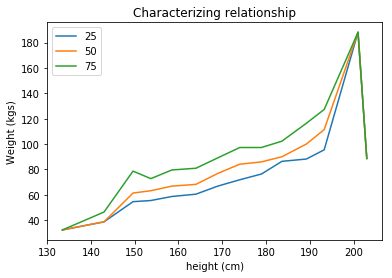

In [22]:
for p in [0.25,0.5,0.75]:
    xs = []
    ys = []
    for i,group in groups:
        wgt = group['wtkg2']
        hts = group['htm3']
        xs.append(np.mean(hts))
        ys.append(percentile(p,wgt))  
    plt.plot(xs,ys,label=int(p*100))
    plt.legend()
    
plt.title('Characterizing relationship')
plt.xlabel('height (cm)')
plt.ylabel('Weight (kgs)')

7.3 Correlation
--

A correlation is a statistic intended to quantify the strength of the relationship between two variables

A challenge in measuring correlation is that the variables we want to compare
are often not expressed in the same units. And even if they are in the same
units, they come from different distributions.

There are two common solutions to these problems:
1. Transform each value to a standard scores, which is the number
of standard deviations from the mean. This transform leads to the
\Pearson product-moment correlation coefficient."
2. Transform each value to its rank, which is its index in the sorted list
of values. This transform leads to the \Spearman rank correlation
coefficient

7.4 Covariance
--

Covariance is a measure of the tendency of two variables to vary together.

If we have two series, X and Y , their deviations from the mean are-

dxi = xi − xmean

dyi = yi − ymean

cov(x,y) = sum(dxi X dyi)/N

In [10]:
def cov(x,y):
    xmean = np.mean(x)
    ymean = np.mean(y)
    
    dxi = [val-xmean for val in x]
    dyi = [val-ymean for val in y]
    
    return np.dot(dxi,dyi)/len(x)
# example
x = [1,2,3,4]
y = [2,4,5,6]
cov(x,y)

1.625

 NumPy and pandas also provide implementations of covariance,
but both of them apply a correction for small sample sizes that we have not
covered yet, and np.cov returns a covariance matrix, which is more than we
need for now

7.5 Pearson's coefficent
--

Covariance is useful in some computations, but it is seldom reported as a
summary statistic because it is hard to interpret. 

Among other problems,
**its units are the product of the units of X and Y** . For example, the covariance of weight and height in the BRFSS dataset is 113 kilogram-centimeters,
whatever that means.

One solution to this problem is to divide the deviations by the standard
deviation, which yields standard scores, and compute the product of standard
scores.

pearson's coefficient (rho) - 

pi = [(xi-xmean)/std(x)] X [(yi-ymean)/std(y)]

rho = sum(pi)/N

In [11]:
def pearson_coeff (x,y):
    x = np.asarray(x)
    y = np.asarray(y)
    
    xmean = np.mean(x)
    ymean = np.mean(y)
    std_x = np.std(x)
    std_y = np.std(y)
    
    xi = [(val-xmean)/std_x for val in x] 
    yi = [(val-ymean)/std_y for val in y]
    
    return sum(xi*np.transpose(yi))/len(x)

x = [1,2,3,4]
y = [2,4,5,6]

print('My function: '+str(pearson_coeff(x,y)))
print('Scipy function: ' +str(stats.pearsonr(x,y)))

My function: 0.982707629823991
Scipy function: (0.9827076298239908, 0.017292370176009157)


In [12]:
print('My function: '+str(pearson_coeff(df['htm3'].values,df['wtkg2'].values)))
print('Scipy function: '+str(stats.pearsonr(df['htm3'].values,df['wtkg2'].values)))

My function: 0.5266330321660286
Scipy function: (0.5266330321660283, 5.675749185057521e-69)


Most correlation in the real world is not perfect, but it is still useful. The correlation of height and weight is 0.51, which is a strong correlation compared
to similar human-related variables.

The magnitude of ρ indicates the strength of the correlation. If ρ is 1 or -1,
the variables are perfectly correlated, which means that if you know one, you
can make a perfect prediction about the other

Pearson’s correlation is always between -1 and +1

7.6 Non-linear relationships
------
In the broadest sense correlation is any statistical association, though in common usage it most often refers to how close two variables are to having a **linear relationship** with each other. Familiar examples of dependent phenomena include the correlation between the physical statures of parents and their offspring, and the correlation between the demand for a limited supply product and its price.

Correlations are useful because they can indicate a predictive relationship that can be exploited in practice. For example, an electrical utility may produce less power on a mild day based on the correlation between electricity demand and weather. In this example, there is a causal relationship, because extreme weather causes people to use more electricity for heating or cooling. However, in general, the presence of a correlation is not sufficient to infer the presence of a causal relationship (i.e., correlation does not imply causation)

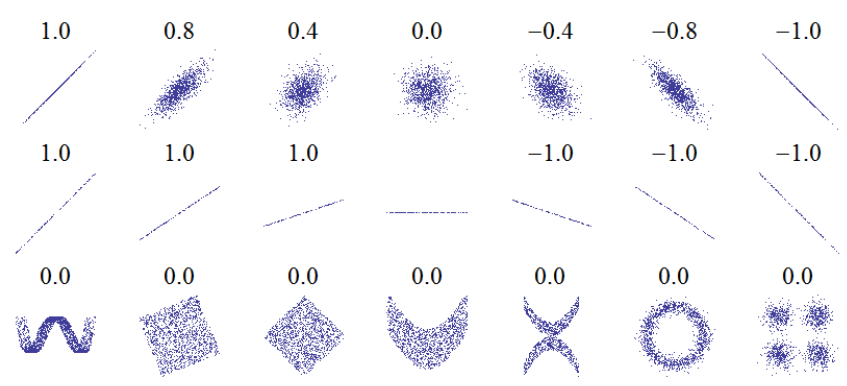

Pearson’s correlation only measures linear relationships. If there’s a nonlinear
relationship, ρ understates its strength. 

If Pearson’s correlation is near 0, it is tempting to conclude that there is no
relationship between the variables, but that conclusion is not valid. Pearson’s correlation only measures linear relationships. If there’s a nonlinear
relationship, ρ understates its strength.

1. The top row shows linear relationships with a range of correlations; you can
use this row to get a sense of what different values of ρ look like. 

2. The second
row shows perfect correlations with a range of slopes, which demonstrates
that correlation is unrelated to slope (we’ll talk about estimating slope soon).

3. The third row shows variables that are clearly related, but because the relationship is nonlinear, the correlation coefficient is 0

**The moral of this story is that you should always look at a scatter plot of
your data before blindly computing a correlation coefficient**


7.7 Spearman's rank coefficient
-----

Spearman’s rank correlation is an alternative that mitigates
the effect of outliers and skewed distributions

In [13]:
x = pd.Series(data=[17,12,13,14])
x.rank()

0    4.0
1    1.0
2    2.0
3    3.0
dtype: float64

In [14]:
def spearman_coeff(x_series,y_series):
    rank1 = x_series.rank()
    rank2 = y_series.rank()
    return pearson_coeff(rank1,rank2)
# after ranking all the values in the series
# then find the pearson's correlation coefficient
print('Pearson\'s coefficient:',pearson_coeff(df['htm3'],df['wtkg2']))
print('Spearman\'s rank coefficient:',spearman_coeff(df['htm3'],df['wtkg2']))

Pearson's coefficient: 0.5266330321660286
Spearman's rank coefficient: 0.5359872660046324


The Spearman rank correlation for the BRFSS data is 0.54, a little higher
than the Pearson correlation, 0.51. There are several possible reasons for the
difference, including:

• If the relationship is nonlinear, Pearson’s correlation tends to underestimate the strength of the relationship, and

• Pearson’s correlation can be affected (in either direction) if one of the
distributions is skewed or contains outliers. Spearman’s rank correlation is more robust

In the BRFSS example, we know that the distribution of weights is roughly
lognormal; under a log transform it approximates a normal distribution

Text(0.5,1,'CDF for Wgts on log-scale')

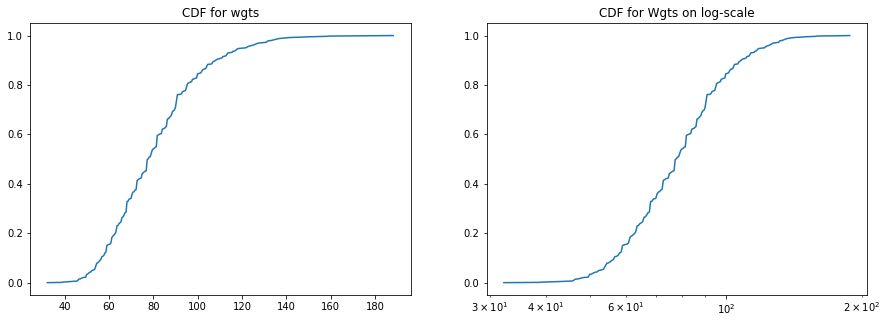

In [15]:
x,y = compute_cdf(df['wtkg2'])

fig = plt.figure()
fig.set_size_inches(15,5)

# add a automated to plot n by n number of subplots with titles and axis labels

# Normal scatter plot
ax1 = plt.subplot(121)
ax1.plot(x,y)
ax1.set_title('CDF for wgts')

# Transperent plot
ax2 = plt.subplot(122)
ax2.plot(x,y)
ax2.set_xscale('log')
ax2.set_title('CDF for Wgts on log-scale')

# to check the validity plot the normal probability plot 


In [16]:
def normal_prob_log_normal(series):
    mean = np.mean(series)
    std = np.std(series)
    N = len(series)
    
    log_series = np.log(series)
    mean_log = np.mean(log_series)
    std_log = np.std(log_series)
    
    std_random_z = sorted(np.random.normal(size=N))
    
    standard = np.linspace(start=stats.norm.ppf(0.0001),stop=stats.norm.ppf(0.9999),num=N)
    normal = np.linspace(start=stats.norm.ppf(0.0001,loc=mean,scale=std),stop=stats.norm.ppf(0.9999,loc=mean,scale=std),num=N)
    normal_log = np.linspace(start=stats.norm.ppf(0.0001,loc=mean_log,scale=std_log),stop=stats.norm.ppf(0.9999,loc=mean_log,scale=std_log),num=N)

    fig = plt.figure()
    fig.set_size_inches(15,5)
    # normal probability plot for data
    ax1 = plt.subplot(121)
    ax1.plot(std_random_z, sorted(series.values),label='Data')    
    # normal probability plot for model
    ax1.plot(standard,normal,label='Model')
    ax1.set_title('Normal values of given data')
    ax1.set_xlabel('standard z-values')
    ax1.set_ylabel('data')
    ax1.legend()
    
    # plot the normal probability plot for log-normal plots
    ax2 = plt.subplot(122)
    ax2.plot(std_random_z, np.log(sorted(series.values)),label='Data')
    ax2.plot(standard,normal_log,label='Model')
    ax2.set_title('Log Normal values of given data')
    ax2.set_xlabel('standard z-values')
    ax2.set_ylabel('data')
    ax2.legend()
# another way of plotting the model normal dist with standard normal dist
    


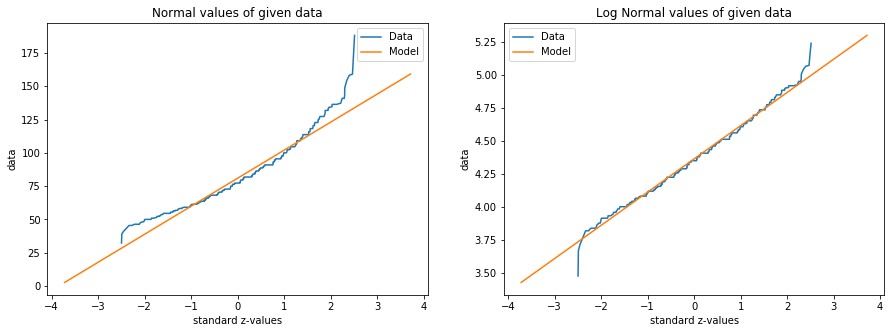

In [17]:
normal_prob_log_normal(df['wtkg2'])

In the BRFSS example, we know that the distribution of weights is roughly
lognormal; under a log transform it approximates a normal distribution, so it **has no skew**. So another way to eliminate the effect of skewness is to compute
Pearson’s correlation with log-weight and height

In [18]:
print('Spearman\'s rank coefficient:',pearson_coeff(df['htm3'],np.log(df['wtkg2'])))
print('Spearman\'s rank coefficient:',spearman_coeff(df['htm3'],df['wtkg2']))

Spearman's rank coefficient: 0.5450578123262364
Spearman's rank coefficient: 0.5359872660046324


So that suggests that
**skewness** in the distribution of weight explains most of the difference between
Pearson’s and Spearman’s correlation

7.8 Correlation and causation
-----

If variables A and B are correlated, there are three possible explanations: A
causes B, or B causes A, or some other set of factors causes both A and B.
These explanations are called \causal relationships.

**"Correlation does not imply causation"**

So what can you do to provide evidence of causation?

1. Use time. If A comes before B, then A can cause B but not the other
way around (at least according to our common understanding of causation). The order of events can help us infer the direction of causation,
but it does not preclude the possibility that something else causes both
A and B.

2. Use randomness. If you divide a large sample into two groups at random and compute the means of almost any variable, you expect the
difference to be small. If the groups are nearly identical in all variables
but one, you can eliminate spurious relationships.
This works even if you don’t know what the relevant variables are, but
it works even better if you do, because you can check that the groups
are identical